# Importing packages and set up

In [25]:

import sys
sys.path.insert(0, 'evoman')
from environment import Environment
from demo_controller import player_controller
import time
import numpy as np
import os
from multiprocess import Pool
import psutil
import statistics
from deap import base, creator
import random
from deap import tools
from array import array
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import scipy

# get number of cpus for multiprocessing
num_cpus = psutil.cpu_count(logical=False)
pool = Pool(num_cpus)

# choose this for not using visuals and thus making experiments faster
headless = 
if headless:
    os.environ["SDL_VIDEODRIVER"] = "dummy"

# set up experiment
experiment_name = "Assigment Task 1"
if not os.path.exists(experiment_name):
    os.makedirs(experiment_name)
ini = time.time()  # sets time marker
n_hidden_neurons = 10
run_mode = 'train' 
# env.state_to_log() # checks environment state

# number of weights for multilayer with 10 hidden neurons
n_vars = 265


# the fitness function, we use the fitness that the environment returns so it is better to compare to the baseline paper
def simulation(x, enemies, player_controller = player_controller, Environment = Environment):
    #unconventional, but necessary to run code on multiple cores to speed up processing 
    n_hidden_neurons = 10
    experiment_name = 'individual_demo'
    env = Environment(experiment_name=experiment_name,
                  enemies=enemies,
                  playermode="ai",
                  player_controller=player_controller(n_hidden_neurons),
                  enemymode="static",
                  level=2,
                  speed="fastest")
    
    f,p,e,t = env.play(pcont=x)
    return f

# setting deap methods - aim is to maximise the fitness function
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# create individuals which contain a strategy vector for self-adaptive mutation - one strategy for each gene
creator.create("Individual", array, typecode="d",
               fitness=creator.FitnessMax, strategy=None)
creator.create("Strategy", array, typecode="d")

def initES(icls, scls, size, imin, imax, smin, smax):
    ind = icls(random.uniform(imin, imax) for _ in range(size))
    ind.strategy = scls(random.uniform(smin, smax) for _ in range(size))
    return ind

IND_SIZE = n_vars # number of weights of the neural network that we will optimize
MIN_VALUE, MAX_VALUE = -1., 1. # Minimum and maximum values of the weights are -1 and 1, respectively
MIN_STRAT, MAX_STRAT = -1., 1. 

# register tools
toolbox = base.Toolbox()
toolbox.register("individual", initES, creator.Individual,
                 creator.Strategy, IND_SIZE, MIN_VALUE, MAX_VALUE, MIN_STRAT, 
                 MAX_STRAT)

#toolbox.register("attribute", np.random.uniform, -1, 1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# toolbox.register("evaluate", simulation)
toolbox.register("survivalselection", tools.selBest)

#to compile statistics
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)
#Make one logbook per enemy and algorithm
logbook_tc_2 = tools.Logbook()
logbook_tc_5 = tools.Logbook()
logbook_tc_7 = tools.Logbook()
logbook_tc_1 = tools.Logbook()

logbook_bc_2 = tools.Logbook()
logbook_bc_5 = tools.Logbook()
logbook_bc_7 = tools.Logbook()
logbook_bc_1 = tools.Logbook()

C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Users\Valen\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Strategy' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


### EAs

In [11]:
# Two point corssover
def twopointcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    #register methods specific for this algorithm 
    toolbox.register("mate", tools.cxESTwoPoint)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)
    
    #evaluationg the individuals, speeded up with multiprocessing
    if __name__ == '__main__':
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit: # to safe the best individual
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # record first random generation
    record = stats.compile(pop)

    #one iteration for each generation 
    for g in range(NGEN):
        # Select parents with tournament selection - we select 200 parents because we want to create 200 children
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        offspring = []
        # create children with two point crossover
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2)
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
               
        # mutate offspring
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values
                
        #evaluate offspring, again speeded up with multiprocessing
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        #select best 100 survivors from offspring (mu, lambda selection) 
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        #Get statistics and save them to the logbook
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit


In [12]:
#blend crossover
def blendcx(CXPB, offsprMUTPB, allelmutpb, tournsize, enemies, logbook):
    # create variables to later save the best individual
    best_ind = 1
    best_fit = -100
    
    #register methods specific for this algorithm
    toolbox.register("mate", tools.cxESBlend, alpha = 0.5)
    toolbox.register("mutate", tools.mutESLogNormal, c = 1, indpb= allelmutpb)
    toolbox.register("parentselection", tools.selTournament, tournsize=tournsize)
    pop = toolbox.population(n=pop_size)
    toolbox.register("evaluate", simulation, enemies=enemies)

    #evaluationg the individuals, speeded up with multiprocessing
    if __name__ == '__main__':
        fitnesses = list(pool.map(toolbox.evaluate, np.array(pop)))
    for i in range(len(pop)):
        pop[i].fitness.values = (fitnesses[i],)
        if fitnesses[i] > best_fit: # to safe the best individual
            best_fit = fitnesses[i]
            best_ind = pop[i]
            
    # record first random generation
    record = stats.compile(pop)
    
    #one iteration for each generation
    for g in range(NGEN):
        # Select parents with tournament selection - we select 200 parents because we want to create 200 children 
        parents = toolbox.parentselection(pop, (2*len(pop)))
        # Clone the selected individuals
        parents = list(map(toolbox.clone, parents))

        
        offspring = []
        # create children with two point crossover
        for parent1, parent2 in zip(parents[::2], parents[1::2]): 
            if random.random() < CXPB:
                child1, child2 = toolbox.mate(parent1, parent2) #Set alpha to 0.5 for now
                del child1.fitness.values
                del child2.fitness.values
                offspring.append(child1)
                offspring.append(child2)
        
        # mutate offspring
        for mutant in offspring:
            if random.random() < offsprMUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        #evaluate offspring, again speeded up with multiprocessing
        if __name__ == '__main__':
            fitnesses = list(pool.map(toolbox.evaluate, np.array(offspring)))
        for i in range(len(offspring)):
            offspring[i].fitness.values = (fitnesses[i],)
            if fitnesses[i] > best_fit:
                best_fit = fitnesses[i]
                best_ind = offspring[i]
        
        #select best 100 survivors from offspring (mu, lambda selection) 
        survivedoffspring = toolbox.survivalselection(offspring, pop_size)
        
        # The population is entirely replaced by the offspring
        pop = survivedoffspring
        
        #Get statistics and save them to the logbook
        record = stats.compile(pop)
        logbook.record(gen= (g +1), evals=30, **record)
        
    return best_ind, best_fit

# Stanard assignment 2 test


# Old code starts here!

# Parameter optimization 

### Warning: takes around 8 hours to run

In [3]:
#Parameter optimization using Gridsearch
# for a two-point crossover
pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = twopointcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2
66.53969812413108

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 3
80.84198857579531

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 4
82.79414710221617

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 2
77.2579311603135

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 3
73.6148763154129

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.2
Crossover Probability: 0.7
Tournament Size: 4
71.96904137437359

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.3
Crossover Probability: 0.7
Tournament Size: 2
68.01754394324428

Offspring Mutation Probability: 0.1
Allele Mutation Probability:

KeyboardInterrupt: 

results first gridsearch
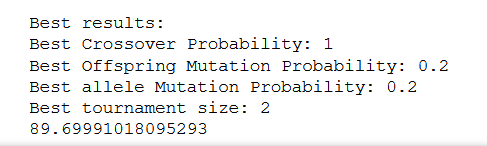

In [6]:
# for blend cx

pop_size = 100
NGEN = 10

best_cxpb = 0
best_offsprmutpb = 0
best_mean = 1
best_tournsize = 0

    
for cxpb in [0.7, 0.85, 1]:
    for offsprmutpb in [0.1, 0.2, 0.3]:
        for allelmutpb in [0.1, 0.2, 0.3]:
            for tournsize in [2, 3, 4]:
                print("Offspring Mutation Probability: " + str(offsprmutpb))
                print("Allele Mutation Probability: " + str(allelmutpb))
                print("Crossover Probability: " + str(cxpb))
                print("Tournament Size: " + str(tournsize))
                best_individuals = []
                best_scores = []
                for i in range(5):
                    best_ind, best_score = blendcx(cxpb, offsprmutpb, allelmutpb, tournsize)
                    best_individuals.append(best_ind)
                    best_scores.append(best_score)
                print(np.mean(best_scores))
                print()
                if np.mean(best_scores) > best_mean:
                    best_mean = np.mean(best_scores)
                    best_cxpb = cxpb
                    best_offsprmutpb = offsprmutpb
                    best_allelmutpb = allelmutpb
                    best_tournsize = tournsize
            
print("Best results: ")
print("Best Crossover Probability: " + str(best_cxpb))
print("Best Offspring Mutation Probability: " + str(best_offsprmutpb))
print("Best allele Mutation Probability: " + str(best_allelmutpb))
print("Best tournament size: " + str(best_tournsize))
print(best_mean)

Offspring Mutation Probability: 0.1
Allele Mutation Probability: 0.1
Crossover Probability: 0.7
Tournament Size: 2


TypeError: blendcx() missing 2 required positional arguments: 'enemies' and 'logbook'

best params where: (1, 0.2, 0.2, 4)

# Experimental runs

#### Fast code

In [13]:
#Initialize base parameters for experimental run
pop_size = 100
NGEN = 30
runs = 10
gens = []
for i in range(NGEN):
    gens.append(i+1)


# Enemy 2

In [14]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_2 = []
best_scores_tc_2 = []
for i in range(runs):
    best_ind_tc_2, best_score_tc_2 = twopointcx(1, 0.2, 0.2, 2, [2], logbook_tc_2) #tournament size was not set
    best_individuals_tc_2.append(best_ind_tc_2)
    best_scores_tc_2.append(best_score_tc_2)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


14629.847719192505

In [15]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_2 = []
best_scores_bc_2 = []
for i in range(runs):
    best_ind_bc_2, best_score_bc_2 = blendcx(1, 0.2, 0.2, 4, [2], logbook_bc_2) #tournament size was not set
    best_individuals_bc_2.append(best_ind_bc_2)
    best_scores_bc_2.append(best_score_bc_2)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


14257.255098581314

# Boxplot for individual gain against enemy 2

In [16]:
#Run the best individuals 5 times against enemy 2 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[2],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_2 = [] 
for indiv in best_individuals_tc_2:
    fiveruns_tc_2 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_2 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_2.append(individual_gain_tc_2)
    means_tc_2.append(np.mean(fiveruns_tc_2)) # Get the mean individual gain over 5 runs of the best individual
means_tc_2
        
        
    


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 2; fitness: 92.65092391510478; player life: 82; enemy life: 0; time: 257

RUN: run status: enemy: 2; fitness: 92.33357331188756; player life: 80; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 92.33357331188756; player life: 80; enemy life: 0; time: 289

RUN: run status: enemy: 2; fitness: 74.39876988127112; player life: 0; enemy life: 10.0; time: 736

RUN: run status: enemy: 2; fitness: 74.39876988127112; player life: 0; enemy life: 10.0; time: 736

RUN: run status: enemy: 2; fitness: 92.04317193830046; player life: 76; enemy life: 0; time: 259

RUN: run status: enemy: 2; fitness: 93.37504998251859; player life: 88; enemy life: 0; time: 227

RUN: run status: enemy: 2; fitness: 92.23931836898447; player life: 78; enemy life: 0; time: 260

RUN: run status: enemy: 2; fitness: 93.37504998251859; player life: 88; enemy life: 0; time: 227

RUN: run status: enemy: 2; fitness: 92.23931836898447; player life: 

[44.4, 81.6, 83.2, 76.4, 82.8, 60.8, 66.4, 41.6, 86.0, 84.0]

In [17]:
#Run the best individuals 5 times against enemy 2 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[2],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_2 = []
for indiv in best_individuals_bc_2:
    fiveruns_bc_2 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_2 = p-e
        fiveruns_bc_2.append(individual_gain_bc_2)
    means_bc_2.append(np.mean(fiveruns_bc_2))
means_bc_2


MESSAGE: Pygame initialized for simulation.

RUN: run status: enemy: 2; fitness: 91.83931836898448; player life: 74; enemy life: 0; time: 260

RUN: run status: enemy: 2; fitness: 93.33214184093667; player life: 86; enemy life: 0; time: 194

RUN: run status: enemy: 2; fitness: 92.56627799644576; player life: 80; enemy life: 0; time: 229

RUN: run status: enemy: 2; fitness: 92.56627799644576; player life: 80; enemy life: 0; time: 229

RUN: run status: enemy: 2; fitness: 93.54250462797222; player life: 88; enemy life: 0; time: 192

RUN: run status: enemy: 2; fitness: 87.33616819497439; player life: 28; enemy life: 0; time: 236

RUN: run status: enemy: 2; fitness: 92.73109579777977; player life: 78; enemy life: 0; time: 159

RUN: run status: enemy: 2; fitness: 86.74250462797222; player life: 20; enemy life: 0; time: 192

RUN: run status: enemy: 2; fitness: 92.73109579777977; player life: 78; enemy life: 0; time: 159

RUN: run status: enemy: 2; fitness: 87.33616819497439; player life: 28; 

[81.6, 46.4, -6.4, 60.4, 89.2, 44.0, 84.0, 47.2, 70.0, 83.2]

Text(0.5, 1.0, "Individual Gain for the defined EA's on enemy 2")

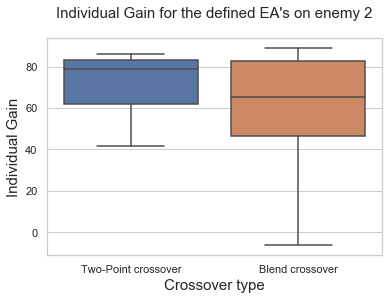

In [19]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
enemy_list_2 = ['2'] * 2 *n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
individual_gains = []
individual_gains.extend(means_tc_2)
individual_gains.extend(means_bc_2)

boxplot_dict_2 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_2}
boxplot_dict_2_pd = pd.DataFrame(boxplot_dict_2)

#sns.set_theme(style="whitegrid")
sns.set(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_2_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 2",pad=20, fontsize = 15)

In [ ]:
import scipy.stats as stats

print(stats.ttest_ind(means_tc_2, means_bc_2))

# Lineplots for average and maximum fitness values against enemy 2

In [31]:
averages_tc_2 = []
standard_devs_tc_2 = []
standard_dev_up_tc_2 = []
standard_dev_min_tc_2 = []

maxima_tc_2 = []
maxima_standard_devs_tc_2 = []
maxima_standard_dev_up_tc_2 = []
maxima_standard_dev_min_tc_2 = []

y_tc_2 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_2 = []
    maxima_of_generation_tc_2 = []
    x_tc_2 = y_tc_2
    
    for j in range(runs):
        averages_of_generation_tc_2.append(logbook_tc_2[x_tc_2]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_2.append(logbook_tc_2[x_tc_2]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_2[x_tc_2]['avg'][0])
        x_tc_2 += 10
    averages_tc_2.append(sum(averages_of_generation_tc_2)/len(averages_of_generation_tc_2))
    maxima_tc_2.append(sum(maxima_of_generation_tc_2)/len(maxima_of_generation_tc_2))    
    standard_devs_tc_2.append((statistics.stdev(averages_of_generation_tc_2))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_2.append((statistics.stdev(maxima_of_generation_tc_2)))
    y_tc_2+=1
    print(i)
    
    
#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_2)
averages_tc_2_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_2)
standard_devs_tc_2_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_2)
maxima_standard_devs_tc_2_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_2)
maxima_tc_2_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_2.append(averages_tc_2_interp[i]+standard_devs_tc_2_interp[i])
    standard_dev_min_tc_2.append(averages_tc_2_interp[i]-standard_devs_tc_2_interp[i])
    maxima_standard_dev_up_tc_2.append(maxima_tc_2_interp[i]+maxima_standard_devs_tc_2_interp[i])
    maxima_standard_dev_min_tc_2.append(maxima_tc_2_interp[i]-maxima_standard_devs_tc_2_interp[i])
    

IndexError: list index out of range

In [30]:
logbook_tc_2

[]

In [21]:
averages_bc_2 = []
standard_devs_bc_2 = []
standard_dev_up_bc_2 = []
standard_dev_min_bc_2 = []

maxima_bc_2 = []
maxima_standard_devs_bc_2 = []
maxima_standard_dev_up_bc_2 = []
maxima_standard_dev_min_bc_2 = []

y_bc_2 = 0
for i in range(NGEN):
    averages_of_generation_bc_2 = []
    maxima_of_generation_bc_2 = []
    x_bc_2 = y_bc_2
    
    for j in range(runs):
        averages_of_generation_bc_2.append(logbook_bc_2[x_bc_2]['avg'][0])
        maxima_of_generation_bc_2.append(logbook_bc_2[x_bc_2]['max'][0])
        x_bc_2 += 10
    averages_bc_2.append(sum(averages_of_generation_bc_2)/len(averages_of_generation_bc_2))
    maxima_bc_2.append(sum(maxima_of_generation_bc_2)/len(maxima_of_generation_bc_2))    
    standard_devs_bc_2.append((statistics.stdev(averages_of_generation_bc_2)))
    maxima_standard_devs_bc_2.append((statistics.stdev(maxima_of_generation_bc_2)))

    y_bc_2+=1

x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_2)
averages_bc_2_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_2)
standard_devs_bc_2_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_2)
maxima_standard_devs_bc_2_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_2)
maxima_bc_2_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_2.append(averages_bc_2_interp[i]+standard_devs_bc_2_interp[i])
    standard_dev_min_bc_2.append(averages_bc_2_interp[i]-standard_devs_bc_2_interp[i])
    maxima_standard_dev_up_bc_2.append(maxima_bc_2_interp[i]+maxima_standard_devs_bc_2_interp[i])
    maxima_standard_dev_min_bc_2.append(maxima_bc_2_interp[i]-maxima_standard_devs_bc_2_interp[i])
    

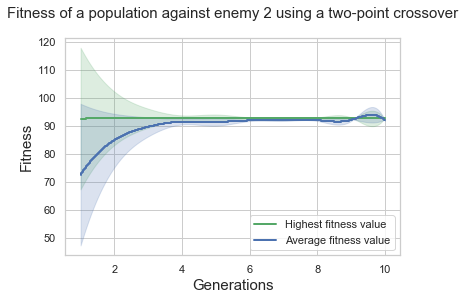

In [22]:
lineplot_2, axes_2 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_2 = 'Mean '

axes_2.step(x_new, maxima_tc_2_interp, label=CB_lab_5, lw=2, color='g')
axes_2.fill_between(x_new, maxima_standard_dev_min_tc_2, maxima_standard_dev_up_tc_2, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_2.step(x_new, averages_tc_2_interp, label=CB_lab_5, lw=2, color='b')
axes_2.fill_between(x_new, standard_dev_min_tc_2, standard_dev_up_tc_2, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 2 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


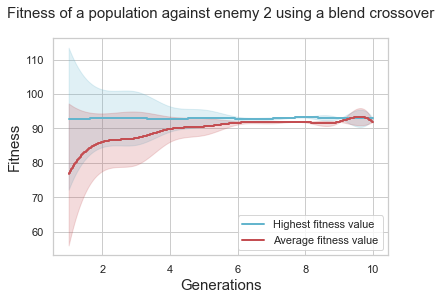

In [23]:
lineplot_2, axes_2 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_2 = 'Mean '

axes_2.step(x_new, maxima_bc_2_interp, label=CB_lab_5, lw=2, color='c')
axes_2.fill_between(x_new, maxima_standard_dev_min_bc_2, maxima_standard_dev_up_bc_2, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_2.step(x_new, averages_bc_2_interp, label=CB_lab_5, lw=2, color='r')
axes_2.fill_between(x_new, standard_dev_min_bc_2, standard_dev_up_bc_2, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 2 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

# Enemy 5

In [ ]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_5 = []
best_scores_tc_5 = []
for i in range(runs):
    best_ind_tc_5, best_score_tc_5 = twopointcx(1, 0.2, 0.2, 2, [5], logbook_tc_5) #tournament size was not set
    best_individuals_tc_5.append(best_ind_tc_5)
    best_scores_tc_5.append(best_score_tc_5)
    print(i)

t1 = time.time()

total = t1-t0
total

In [ ]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_5 = []
best_scores_bc_5 = []
for i in range(runs):
    best_ind_bc_5, best_score_bc_5 = blendcx(1, 0.2, 0.2, 4, [5], logbook_bc_5) #tournament size was not set
    best_individuals_bc_5.append(best_ind_bc_5)
    best_scores_bc_5.append(best_score_bc_5)
    print(i)

t1 = time.time()

total = t1-t0
total

# Boxplot for individual gain against Enemy 5

In [ ]:
#Run the best individuals 5 times against Enemy 5 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[5],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_5 = [] 
for indiv in best_individuals_tc_5:
    fiveruns_tc_5 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_5 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_5.append(individual_gain_tc_5)
    means_tc_5.append(np.mean(fiveruns_tc_5)) # Get the mean individual gain over 5 runs of the best individual
means_tc_5
        
        
    

In [ ]:
#Run the best individuals 5 times against Enemy 5 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[5],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_5 = []
for indiv in best_individuals_bc_5:
    fiveruns_bc_5 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_5 = p-e
        fiveruns_bc_5.append(individual_gain_bc_5)
    means_bc_5.append(np.mean(fiveruns_bc_5))
means_bc_5

In [ ]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_5 = ['5'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_5)
individual_gains.extend(means_bc_5)

boxplot_dict_5 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_5}
boxplot_dict_5_pd = pd.DataFrame(boxplot_dict_5)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_5_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 5",pad=20, fontsize = 15)

# Lineplots for average and maximum fitness values against Enemy 5

In [ ]:
averages_tc_5 = []
standard_devs_tc_5 = []
standard_dev_up_tc_5 = []
standard_dev_min_tc_5 = []

maxima_tc_5 = []
maxima_standard_devs_tc_5 = []
maxima_standard_dev_up_tc_5 = []
maxima_standard_dev_min_tc_5 = []

y_tc_5 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_5 = []
    maxima_of_generation_tc_5 = []
    x_tc_5 = y_tc_5
    
    for j in range(runs):
        averages_of_generation_tc_5.append(logbook_tc_5[x_tc_5]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_5.append(logbook_tc_5[x_tc_5]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_5[x_tc_5]['avg'][0])
        x_tc_5 += 10
    averages_tc_5.append(sum(averages_of_generation_tc_5)/len(averages_of_generation_tc_5))
    maxima_tc_5.append(sum(maxima_of_generation_tc_5)/len(maxima_of_generation_tc_5))    
    standard_devs_tc_5.append((statistics.stdev(averages_of_generation_tc_5))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_5.append((statistics.stdev(maxima_of_generation_tc_5)))
    y_tc_5+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_5)
averages_tc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_5)
standard_devs_tc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_5)
maxima_standard_devs_tc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_5)
maxima_tc_5_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_5.append(averages_tc_5_interp[i]+standard_devs_tc_5_interp[i])
    standard_dev_min_tc_5.append(averages_tc_5_interp[i]-standard_devs_tc_5_interp[i])
    maxima_standard_dev_up_tc_5.append(maxima_tc_5_interp[i]+maxima_standard_devs_tc_5_interp[i])
    maxima_standard_dev_min_tc_5.append(maxima_tc_5_interp[i]-maxima_standard_devs_tc_5_interp[i])
    

In [ ]:
averages_bc_5 = []
standard_devs_bc_5 = []
standard_dev_up_bc_5 = []
standard_dev_min_bc_5 = []

maxima_bc_5 = []
maxima_standard_devs_bc_5 = []
maxima_standard_dev_up_bc_5 = []
maxima_standard_dev_min_bc_5 = []

y_bc_5 = 0
for i in range(NGEN):
    averages_of_generation_bc_5 = []
    maxima_of_generation_bc_5 = []
    x_bc_5 = y_bc_5
    
    for j in range(runs):
        averages_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['avg'][0])
        maxima_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['max'][0])
        x_bc_5 += 10
    averages_bc_5.append(sum(averages_of_generation_bc_5)/len(averages_of_generation_bc_5))
    maxima_bc_5.append(sum(maxima_of_generation_bc_5)/len(maxima_of_generation_bc_5))    
    standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    maxima_standard_devs_bc_5.append((statistics.stdev(maxima_of_generation_bc_5)))

    y_bc_5+=1

x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_5)
averages_bc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_5)
standard_devs_bc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_5)
maxima_standard_devs_bc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_5)
maxima_bc_5_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_5.append(averages_bc_5_interp[i]+standard_devs_bc_5_interp[i])
    standard_dev_min_bc_5.append(averages_bc_5_interp[i]-standard_devs_bc_5_interp[i])
    maxima_standard_dev_up_bc_5.append(maxima_bc_5_interp[i]+maxima_standard_devs_bc_5_interp[i])
    maxima_standard_dev_min_bc_5.append(maxima_bc_5_interp[i]-maxima_standard_devs_bc_5_interp[i])
    

In [ ]:
lineplot_5, axes_5 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_5 = 'Mean '

axes_5.step(x_new, maxima_tc_5_interp, label=CB_lab_5, lw=2, color='g')
axes_5.fill_between(x_new, maxima_standard_dev_min_tc_5, maxima_standard_dev_up_tc_5, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_5.step(x_new, averages_tc_5_interp, label=CB_lab_5, lw=2, color='b')
axes_5.fill_between(x_new, standard_dev_min_tc_5, standard_dev_up_tc_5, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 5 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


In [ ]:
lineplot_5, axes_5 = plt.subplots()
CB_lab_5 = 'Mean PR-curve CatBoost ()' 
lineplot_title_5 = 'Mean '

axes_5.step(x_new, maxima_bc_5_interp, label=CB_lab_5, lw=2, color='c')
axes_5.fill_between(x_new, maxima_standard_dev_min_bc_5, maxima_standard_dev_up_bc_5, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_5.step(x_new, averages_bc_5_interp, label=CB_lab_5, lw=2, color='r')
axes_5.fill_between(x_new, standard_dev_min_bc_5, standard_dev_up_bc_5, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 5 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

In [ ]:
averages_bc_5 = []
standard_devs_bc_5 = []
standard_dev_up_bc_5 = []
standard_dev_min_bc_5 = []

maxima_bc_5 = []
maxima_standard_devs_bc_5 = []
maxima_standard_dev_up_bc_5 = []
maxima_standard_dev_min_bc_5 = []

y_bc_5 = 0
for i in range(NGEN):
    averages_of_generation_bc_5 = []
    maxima_of_generation_bc_5 = []
    x_bc_5 = y_bc_5
    
    for j in range(runs):
        averages_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['avg'][0])
        maxima_of_generation_bc_5.append(logbook_bc_5[x_bc_5]['max'][0])

        print(logbook_bc_5[x_bc_5]['avg'][0])
        x_bc_5 += 10
    averages_bc_5.append(sum(averages_of_generation_bc_5)/len(averages_of_generation_bc_5))
    maxima_bc_5.append(sum(maxima_of_generation_bc_5)/len(maxima_of_generation_bc_5))    
    standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    maxima_standard_devs_bc_5.append((statistics.stdev(maxima_of_generation_bc_5)))

    y_bc_5+=1

x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_5)
averages_bc_5_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_5)
standard_devs_bc_5_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_5)
maxima_standard_devs_bc_5_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_5)
maxima_bc_5_interp = a_BSpline(x_new)

for i in range(300):
#     standard_devs_bc_5.append((statistics.stdev(averages_of_generation_bc_5)))
    standard_dev_up_bc_5.append(averages_bc_5_interp[i]+standard_devs_bc_5_interp[i])
    standard_dev_min_bc_5.append(averages_bc_5_interp[i]-standard_devs_bc_5_interp[i])
    maxima_standard_dev_up_bc_5.append(maxima_bc_5_interp[i]+maxima_standard_devs_bc_5_interp[i])
    maxima_standard_dev_min_bc_5.append(maxima_bc_5_interp[i]-maxima_standard_devs_bc_5_interp[i])
    

# Enemy 7

In [ ]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_7 = []
best_scores_tc_7 = []
for i in range(runs):
    best_ind_tc_7, best_score_tc_7 = twopointcx(1, 0.2, 0.2, 2, [7], logbook_tc_7) #tournament size was not set
    best_individuals_tc_7.append(best_ind_tc_7)
    best_scores_tc_7.append(best_score_tc_7)
    print(i)

t1 = time.time()

total = t1-t0
total

In [ ]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_7 = []
best_scores_bc_7 = []
for i in range(runs):
    best_ind_bc_7, best_score_bc_7 = blendcx(1, 0.2, 0.2, 4, [7], logbook_bc_7) #tournament size was not set
    best_individuals_bc_7.append(best_ind_bc_7)
    best_scores_bc_7.append(best_score_bc_7)
    print(i)

t1 = time.time()

total = t1-t0
total

# Boxplot for individual gain against Enemy 7

In [ ]:
#Run the best individuals 5 times against Enemy 7 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[7],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_7 = [] 
for indiv in best_individuals_tc_7:
    fiveruns_tc_7 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_7 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_7.append(individual_gain_tc_7)
    means_tc_7.append(np.mean(fiveruns_tc_7)) # Get the mean individual gain over 5 runs of the best individual
means_tc_7
        
        
    

In [ ]:
#Run the best individuals 5 times against Enemy 7 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[7],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_7 = []
for indiv in best_individuals_bc_7:
    fiveruns_bc_7 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_7 = p-e
        fiveruns_bc_7.append(individual_gain_bc_7)
    means_bc_7.append(np.mean(fiveruns_bc_7))
means_bc_7

In [ ]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_2 = ['7'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_7)
individual_gains.extend(means_bc_7)

boxplot_dict_7 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_2}
boxplot_dict_7_pd = pd.DataFrame(boxplot_dict_7)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_7_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 7",pad=20, fontsize = 15)

# Lineplots for average and maximum fitness values against Enemy 7

In [ ]:
averages_tc_7 = []
standard_devs_tc_7 = []
standard_dev_up_tc_7 = []
standard_dev_min_tc_7 = []

maxima_tc_7 = []
maxima_standard_devs_tc_7 = []
maxima_standard_dev_up_tc_7 = []
maxima_standard_dev_min_tc_7 = []

y_tc_7 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_7 = []
    maxima_of_generation_tc_7 = []
    x_tc_7 = y_tc_7
    
    for j in range(runs):
        averages_of_generation_tc_7.append(logbook_tc_7[x_tc_7]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_7.append(logbook_tc_7[x_tc_7]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_7[x_tc_7]['avg'][0])
        x_tc_7 += 10
    averages_tc_7.append(sum(averages_of_generation_tc_7)/len(averages_of_generation_tc_7))
    maxima_tc_7.append(sum(maxima_of_generation_tc_7)/len(maxima_of_generation_tc_7))    
    standard_devs_tc_7.append((statistics.stdev(averages_of_generation_tc_7))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_7.append((statistics.stdev(maxima_of_generation_tc_7)))
    y_tc_7+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_7)
averages_tc_7_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_7)
standard_devs_tc_7_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_7)
maxima_standard_devs_tc_7_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_7)
maxima_tc_7_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_7.append(averages_tc_7_interp[i]+standard_devs_tc_7_interp[i])
    standard_dev_min_tc_7.append(averages_tc_7_interp[i]-standard_devs_tc_7_interp[i])
    maxima_standard_dev_up_tc_7.append(maxima_tc_7_interp[i]+maxima_standard_devs_tc_7_interp[i])
    maxima_standard_dev_min_tc_7.append(maxima_tc_7_interp[i]-maxima_standard_devs_tc_7_interp[i])
    

In [ ]:
averages_bc_7 = []
standard_devs_bc_7 = []
standard_dev_up_bc_7 = []
standard_dev_min_bc_7 = []

maxima_bc_7 = []
maxima_standard_devs_bc_7 = []
maxima_standard_dev_up_bc_7 = []
maxima_standard_dev_min_bc_7 = []

y_bc_7 = 0
for i in range(NGEN):
    averages_of_generation_bc_7 = []
    maxima_of_generation_bc_7 = []
    x_bc_7 = y_bc_7
    
    for j in range(runs):
        averages_of_generation_bc_7.append(logbook_bc_7[x_bc_7]['avg'][0])
        maxima_of_generation_bc_7.append(logbook_bc_7[x_bc_7]['max'][0])
        x_bc_7 += 10
    averages_bc_7.append(sum(averages_of_generation_bc_7)/len(averages_of_generation_bc_7))
    maxima_bc_7.append(sum(maxima_of_generation_bc_7)/len(maxima_of_generation_bc_7))    
    standard_devs_bc_7.append((statistics.stdev(averages_of_generation_bc_7)))
    maxima_standard_devs_bc_7.append((statistics.stdev(maxima_of_generation_bc_7)))

    y_bc_7+=1

x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_7)
averages_bc_7_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_7)
standard_devs_bc_7_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_7)
maxima_standard_devs_bc_7_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_7)
maxima_bc_7_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_7.append(averages_bc_7_interp[i]+standard_devs_bc_7_interp[i])
    standard_dev_min_bc_7.append(averages_bc_7_interp[i]-standard_devs_bc_7_interp[i])
    maxima_standard_dev_up_bc_7.append(maxima_bc_7_interp[i]+maxima_standard_devs_bc_7_interp[i])
    maxima_standard_dev_min_bc_7.append(maxima_bc_7_interp[i]-maxima_standard_devs_bc_7_interp[i])
    

In [ ]:
lineplot_7, axes_7 = plt.subplots()
CB_lab_7 = 'Mean PR-curve CatBoost ()' 
lineplot_title_7 = 'Mean '

axes_7.step(x_new, maxima_tc_7_interp, label=CB_lab_7, lw=2, color='g')
axes_7.fill_between(x_new, maxima_standard_dev_min_tc_7, maxima_standard_dev_up_tc_7, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_7.step(x_new, averages_tc_7_interp, label=CB_lab_7, lw=2, color='b')
axes_7.fill_between(x_new, standard_dev_min_tc_7, standard_dev_up_tc_7, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 7 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


In [ ]:
lineplot_7, axes_7 = plt.subplots()
CB_lab_7 = 'Mean PR-curve CatBoost ()' 
lineplot_title_7 = 'Mean '

axes_7.step(x_new, maxima_bc_7_interp, label=CB_lab_7, lw=2, color='c')
axes_7.fill_between(x_new, maxima_standard_dev_min_bc_7, maxima_standard_dev_up_bc_7, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_7.step(x_new, averages_bc_7_interp, label=CB_lab_7, lw=2, color='r')
axes_7.fill_between(x_new, standard_dev_min_bc_7, standard_dev_up_bc_7, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 7 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

# Enemy 1

In [26]:
#TC stands for two-point crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_tc_1 = []
best_scores_tc_1 = []
for i in range(runs):
    best_ind_tc_1, best_score_tc_1 = twopointcx(1, 0.2, 0.2, 2, [1], logbook_tc_1) #tournament size was not set
    best_individuals_tc_1.append(best_ind_tc_1)
    best_scores_tc_1.append(best_score_tc_1)
    print(i)

t1 = time.time()

total = t1-t0
total

0
1
2
3
4
5
6
7
8
9


2269.9444451332092

In [ ]:
#BC stands for blend crossover
#Run the EA for NGEN generations and 10 runs
t0 = time.time()

best_individuals_bc_1 = []
best_scores_bc_1 = []
for i in range(runs):
    best_ind_bc_1, best_score_bc_1 = blendcx(1, 0.2, 0.2, 4, [1], logbook_bc_1) #tournament size was not set
    best_individuals_bc_1.append(best_ind_bc_1)
    best_scores_bc_1.append(best_score_bc_1)
    print(i)

t1 = time.time()

total = t1-t0
total

# Boxplot for individual gain against Enemy 1

In [ ]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a two point crossover
env = Environment(experiment_name=experiment_name,
              enemies=[1],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_tc_1 = [] 
for indiv in best_individuals_tc_1:
    fiveruns_tc_1 = []
    for i in range(5): #Do 5 runs to ensure that the fitness value was not achieved by luck
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_tc_1 = p-e #Calculate individual gain using the player and enemies' life
        fiveruns_tc_1.append(individual_gain_tc_1)
    means_tc_1.append(np.mean(fiveruns_tc_1)) # Get the mean individual gain over 5 runs of the best individual
means_tc_1
        
        
    

In [ ]:
#Run the best individuals 5 times against Enemy 1 using an EA that uses a blend crossover
env = Environment(experiment_name=experiment_name,
              enemies=[1],
              playermode="ai",
              player_controller=player_controller(n_hidden_neurons),
              enemymode="static",
              level=2,
              speed="fastest")
means_bc_1 = []
for indiv in best_individuals_bc_1:
    fiveruns_bc_1 = []
    for i in range(5):
        f,p,e,t = env.play(pcont=np.array(indiv))
        individual_gain_bc_1 = p-e
        fiveruns_bc_1.append(individual_gain_bc_1)
    means_bc_1.append(np.mean(fiveruns_bc_1))
means_bc_1

In [ ]:
n = 10
crossover_types = []
two_point_crossover_list = ['Two-Point crossover'] * n # Make lists with crossover type names for a dataframe
blend_crossover_list = ['Blend crossover'] * n
crossover_types.extend(two_point_crossover_list)
crossover_types.extend(blend_crossover_list)
enemy_list_1 = ['1'] * 2 *n

individual_gains = []
individual_gains.extend(means_tc_1)
individual_gains.extend(means_bc_1)

boxplot_dict_1 = {'Individual Gain': individual_gains, 'Crossover type': crossover_types, 'Enemy': enemy_list_1}
boxplot_dict_1_pd = pd.DataFrame(boxplot_dict_1)

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x="Crossover type", y="Individual Gain", data=boxplot_dict_1_pd)
ax.set_xlabel("Crossover type", fontsize = 15)
ax.set_ylabel("Individual Gain", fontsize = 15)
ax.set_title("Individual Gain for the defined EA's on enemy 1",pad=20, fontsize = 15)

# Lineplots for average and maximum fitness values against Enemy 1

In [ ]:
averages_tc_1 = []
standard_devs_tc_1 = []
standard_dev_up_tc_1 = []
standard_dev_min_tc_1 = []

maxima_tc_1 = []
maxima_standard_devs_tc_1 = []
maxima_standard_dev_up_tc_1 = []
maxima_standard_dev_min_tc_1 = []

y_tc_1 = 0
for i in range(NGEN): #Save the average and maximum fitness value of the generation over different runs
    averages_of_generation_tc_1 = []
    maxima_of_generation_tc_1 = []
    x_tc_1 = y_tc_1
    
    for j in range(runs):
        averages_of_generation_tc_1.append(logbook_tc_1[x_tc_1]['avg'][0]) #Save the average value of a generation in a run
        maxima_of_generation_tc_1.append(logbook_tc_1[x_tc_1]['max'][0]) #Save the maximum value of a generation in a run

        print(logbook_tc_1[x_tc_1]['avg'][0])
        x_tc_1 += 10
    averages_tc_1.append(sum(averages_of_generation_tc_1)/len(averages_of_generation_tc_1))
    maxima_tc_1.append(sum(maxima_of_generation_tc_1)/len(maxima_of_generation_tc_1))    
    standard_devs_tc_1.append((statistics.stdev(averages_of_generation_tc_1))) # Calculate standard deviation of NGEN number of means
    maxima_standard_devs_tc_1.append((statistics.stdev(maxima_of_generation_tc_1)))
    y_tc_1+=1

#As we only have 10  fitness values we now interpolate the values in order to get a smooth plot of the maximum and average values
x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_tc_1)
averages_tc_1_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_tc_1)
standard_devs_tc_1_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_tc_1)
maxima_standard_devs_tc_1_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_tc_1)
maxima_tc_1_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_tc_1.append(averages_tc_1_interp[i]+standard_devs_tc_1_interp[i])
    standard_dev_min_tc_1.append(averages_tc_1_interp[i]-standard_devs_tc_1_interp[i])
    maxima_standard_dev_up_tc_1.append(maxima_tc_1_interp[i]+maxima_standard_devs_tc_1_interp[i])
    maxima_standard_dev_min_tc_1.append(maxima_tc_1_interp[i]-maxima_standard_devs_tc_1_interp[i])
    

In [ ]:
averages_bc_1 = []
standard_devs_bc_1 = []
standard_dev_up_bc_1 = []
standard_dev_min_bc_1 = []

maxima_bc_1 = []
maxima_standard_devs_bc_1 = []
maxima_standard_dev_up_bc_1 = []
maxima_standard_dev_min_bc_1 = []

y_bc_1 = 0
for i in range(NGEN):
    averages_of_generation_bc_1 = []
    maxima_of_generation_bc_1 = []
    x_bc_1 = y_bc_1
    
    for j in range(runs):
        averages_of_generation_bc_1.append(logbook_bc_1[x_bc_1]['avg'][0])
        maxima_of_generation_bc_1.append(logbook_bc_1[x_bc_1]['max'][0])
        x_bc_1 += 10
    averages_bc_1.append(sum(averages_of_generation_bc_1)/len(averages_of_generation_bc_1))
    maxima_bc_1.append(sum(maxima_of_generation_bc_1)/len(maxima_of_generation_bc_1))    
    standard_devs_bc_1.append((statistics.stdev(averages_of_generation_bc_1)))
    maxima_standard_devs_bc_1.append((statistics.stdev(maxima_of_generation_bc_1)))

    y_bc_1+=1

x_new = np.linspace(1, 10, 300)
a_BSpline = scipy.interpolate.make_interp_spline(gens, averages_bc_1)
averages_bc_1_interp = a_BSpline(x_new)

b_BSpline = scipy.interpolate.make_interp_spline(gens, standard_devs_bc_1)
standard_devs_bc_1_interp = b_BSpline(x_new)

c_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_standard_devs_bc_1)
maxima_standard_devs_bc_1_interp = b_BSpline(x_new)

a_BSpline = scipy.interpolate.make_interp_spline(gens, maxima_bc_1)
maxima_bc_1_interp = a_BSpline(x_new)

for i in range(300):
    standard_dev_up_bc_1.append(averages_bc_1_interp[i]+standard_devs_bc_1_interp[i])
    standard_dev_min_bc_1.append(averages_bc_1_interp[i]-standard_devs_bc_1_interp[i])
    maxima_standard_dev_up_bc_1.append(maxima_bc_1_interp[i]+maxima_standard_devs_bc_1_interp[i])
    maxima_standard_dev_min_bc_1.append(maxima_bc_1_interp[i]-maxima_standard_devs_bc_1_interp[i])
    

In [ ]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_tc_1_interp, label=CB_lab_1, lw=2, color='g')
axes_1.fill_between(x_new, maxima_standard_dev_min_tc_1, maxima_standard_dev_up_tc_1, color='g', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_tc_1_interp, label=CB_lab_1, lw=2, color='b')
axes_1.fill_between(x_new, standard_dev_min_tc_1, standard_dev_up_tc_1, color='b', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 1 using a two-point crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")


In [ ]:
lineplot_1, axes_1 = plt.subplots()
CB_lab_1 = 'Mean PR-curve CatBoost ()' 
lineplot_title_1 = 'Mean '

axes_1.step(x_new, maxima_bc_1_interp, label=CB_lab_1, lw=2, color='c')
axes_1.fill_between(x_new, maxima_standard_dev_min_bc_1, maxima_standard_dev_up_bc_1, color='c', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')
axes_1.step(x_new, averages_bc_1_interp, label=CB_lab_1, lw=2, color='r')
axes_1.fill_between(x_new, standard_dev_min_bc_1, standard_dev_up_bc_1, color='r', alpha=.2,
                label=r'$\pm$ 1 std. dev. CatBoost')

plt.xlabel("Generations", fontsize = 15)
plt.ylabel("Fitness", fontsize = 15)
plt.title("Fitness of a population against enemy 1 using a blend crossover", pad=20, fontsize = 15)
plt.legend(["Highest fitness value", "Average fitness value"], loc ="lower right")

In [ ]:
total_boxplot_pd = pd.concat([boxplot_dict_2_pd, boxplot_dict_5_pd, boxplot_dict_7_pd], axis=0)

In [ ]:
total_boxplot_pd

In [ ]:
ax = sns.boxplot(x="Enemy", y="Individual Gain", hue="Crossover type",
                 data=total_boxplot_pd, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
